In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/opt/app-root/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd

df = pd.read_csv('response.csv') 
df = df.fillna('')
df['response']=df.iloc[:,3]+df.iloc[:,5]+df.iloc[:,6]
df['issue'] = df.iloc[:,1]
df['symptom'] = df.iloc[:,2] + df.iloc[:,4]
subset = df.iloc[:,-3:]
subset

,response,issue,symptom
0,my brakes make a noise whenever I try to stop,Brakes,Car makes grinding noise
1,super frustrating every time I start my car it...,Starter,Car starts then stops
2,I can't open the damn door to my car,Other,
3,I turn the key and nothing happens,Starter,Car doesn't start
4,Car doesn't always start when it's low on blin...,Starter,Car doesn't start
...,...,...,...
104,my breaks are faulty.,Brakes,"Car brakes, but then brakes disengage"
105,my lights do not work,Other,
106,I try to start the engine only to find that th...,Starter,Car doesn't start
107,The driver side window auto function does not ...,Other,


In [3]:
import markovify
import codecs

In [24]:
#markovify is a simple, extensible Markov chain generator
#Its primary use is for building Markov models of large corpora of text and generating random sentences from that.


#builds the model according to what issue (e.g. brakes, starter, other) is given
def train_markov_type(data, issue):
    return markovify.Text(data[data["issue"] == issue].response, retain_original=False, state_size=2)

#takes one of the 'issue' models and creates a randomly-generated sentence of length up to 200 characters.  Note only creates '1' sentence
def make_sentence(model, length=100):
    return model.make_short_sentence(length, max_overlap_ratio = .7, max_overlap_total=15)

other_model = train_markov_type(subset, "Other")
brakes_model = train_markov_type(subset, "Brakes")
starter_model = train_markov_type(subset, "Starter")

In [25]:
make_sentence(other_model)  #creates a sentence that should be an example of 'other' issue(category)

'There is a light that came on that looks to be something related to the left.'

In [26]:
make_sentence(brakes_model)  #creates a sentence that should be an example of 'brakes' issue(category)

'Plus it seems it takes more force to stop'

In [27]:
make_sentence(starter_model)   #creates a sentence that should be an example of 'starter' issue(category)

'When I try to start the engine doesn’t power up'

We can combine these models with relative weights

In [21]:
#create a compound model in which the sentences that come out will be 2x as many 'other' than 'brakes' or 'starters'

compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])  

In [32]:
#make 20 sentences out of the compound model - copy the text into a spreadsheet and check the count of the issues  (e.g. how many brake issue are there?)

for i in range(28):
    print(make_sentence(compound_model))

When I put the car is making a clicking noise.
My back seat seatbelt won't lock.
sometimes, it won't turn on, but it won't go up at all!
Squealing sound
When turning, the car does slow, but it definitely was not starting.
I turn the wheel.
My car is talking to me through the radio and a/c off, trying to jump start it.
The rotors are warped so it's difficult to push the break pedal without lurching.
This generally does not happen at very high speeds, but generally tolerable at or above 80.
My cars breaks make noises and also take more time to come to a complete stop.
I have the button pushed in and the car evaluated.
Everything seems to be wearing down at different rates.
When coming to a complete stop.
If I try to start the car, turn the radio and asking me if I know where the All Spark is hidden
I can't open the damn door to my car but it won't turn on, but it won't turn off either.
This must be a sensor issue on this tire, but I'm not sure.
Car makes a grinding noise as I drive.
the 

In [10]:
import numpy
def generate_cases(models, weights=None):
    if weights is None:
        weights = [1] * len(models)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]


    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    
    while True:
        yield (make_sentence(choose_model()))
            

In [11]:
#compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])  

t = generate_cases([other_model, brakes_model, starter_model], [3,4,4])  #actual sentences



In [12]:
[next(t) for i in range(100)]  #create 100 sentences

['brake pads are not wearing down evenly',
 "I can't drive that way, always these bullshitty new technologies...",
 'windshield wipers',
 "Sometimes when I press the brake, the car doesn't respond immediately.",
 'My car does not turn over.',
 'I feel a bit harder than I normally would.',
 'My car makes a grinding noise too.',
 'I have a keyless start system and when I step on the the fourth time.',
 'If I pump the brake pedal',
 'I have the button pushed in and the batteries just keep dying after about a week.',
 'When coming to a complete stop, but then starts rolling again even if I push hard on the brake it works better.',
 'I can hear the starter with a hammer.',
 "When I tried to drive, the car doesn't seem to stop",
 'My car does not turn over.',
 'When I tried to drive, the car does slow, but it takes more force to stop',
 "That's all good.",
 'Sometimes when I press the brake, the car does not happen at very high speeds, but rather at speeds of around 30-40 mph.',
 'It makes a

Checking for similarity (slow)

In [ ]:
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#in your terminal window, execute the following code, before loading 'en_core_web_sm':
#     cd vehicle-claims-processing/
#     python -m spacy download en_core_web_sm


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, 

Mean similarity: 0.8046729318755124
[0.7719163897847588, 1.0, 0.9582217248894436, 0.8419749711125252, 0.6632674682437107, 1.0, 1.0, 0.9064304613771647, 0.7365743678296388, 0.9212117714506375, 0.8065920147112234, 0.7726217282368428, 0.8056823369705565, 0.8526804182216756, 0.8043378292358959, 0.8304067451579549, 0.5272897972759032, 0.7181275284009544, 0.5677476852512697, 1.0, 0.7291098415833142, 0.855793609229526, 0.7269302582944932, 0.7077358889264597, 0.7269302582944932, 1.0, 0.7919561688398696, 1.0, 0.4845971121994884, 0.8352848402160005, 0.7291098415833142, 1.0, 0.5734288314889731, 0.7632864516088832, 0.753279249675599, 1.0, 0.8451555708947686, 0.6992963561982924, 0.7710974659842822, 0.7729148619016389, 0.7097855100377055, 0.6144685359639674, 0.7857739365949139, 0.7561121363235664, 1.0, 0.7704393063217706, 0.5272897972759032, 0.6277181723330252, 0.7846928492919893, 1.0, 1.0, 0.6766291231204512, 0.7878587659128863, 0.5677476852512697, 0.6766291231204512, 1.0, 0.8999214307132786, 0.893

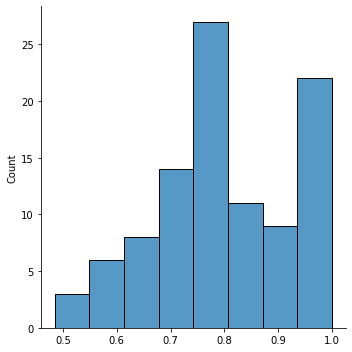

In [33]:
import spacy

#spacy is a free industrial-strenth NLP in python (https://spacy.io/)
#en_core_web_sm is an english pipeline optimized for cpu.  components: tok2vec, tagger, prser, senter, ner, attribure_rulter, lemmantizer

nlp = spacy.load('en_core_web_sm')  #the nlp is going to tokenize the lists dt_b, dt_a
#nlp = spacy.load('en')

dt_b = subset["response"]  #109 responses (from our google form) in our response.csv
dt_a = [next(t) for i in range(100)]  #created sentences from 3 models that were combined.  Remember the 3 models were (created) based on the the reponse.csv issues (categories)

import numpy as np
a = []
for sentence in dt_a:
    doc = nlp(sentence)
    m = 0
    for sentence1 in dt_b:
        doc1 = nlp(sentence1)
        if m < doc.similarity(doc1):
            m = doc.similarity(doc1)  #m is taking the highest similarity of all the comparisons made  (a[] is a bunch of numbers between 1 and -1)
    a.append(m)
        
print("Mean similarity: " + str(np.array(a).mean()))
print(a)

import seaborn as sns
sns.displot(a)

#plotting generated sentences vs google form sentences.  For each google form sentence, what was the most similiar in the list of generated sentences.
#have a fairly normal distributation which demonstrates that our nlp generation isn't bad :)

In [34]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [35]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

Sun Mar 21 22:33:22 2021    generatestats

         294240 function calls (269838 primitive calls) in 0.157 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2000    0.002    0.000    0.009    0.000 <ipython-input-10-5f1382f3447f>:13(choose_model)
     2000    0.001    0.000    0.156    0.000 <ipython-input-10-5f1382f3447f>:2(generate_cases)
     2000    0.002    0.000    0.145    0.000 <ipython-input-24-d930d16f82f3>:6(make_sentence)
        1    0.001    0.001    0.157    0.157 <ipython-input-34-801ca619797e>:3(timing)
        1    0.000    0.000    0.157    0.157 <string>:1(<module>)
    61849    0.017    0.000    0.025    0.000 chain.py:10(accumulate)
    26435    0.019    0.000    0.122    0.000 chain.py:112(gen)
     2033    0.006    0.000    0.128    0.000 chain.py:125(walk)
    26435    0.065    0.000    0.103    0.000 chain.py:96(move)
     2033    0.001    0.000    0.002    0.000 text.py:120(word_join)
     203